# Import Dependencies

<div dir="rtl">

    توضیحات:
    این سلول تمام کتابخانه‌ها و ماژول‌های مورد نیاز برای اجرای پروژه را وارد می‌کند.

        torch و torch.nn برای محاسبات تنسور و شبکه عصبی.

        pymoo برای الگوریتم‌های بهینه‌سازی تکاملی.

        numpy و matplotlib برای محاسبات عددی و رسم نمودارها.

    کاربرد:
    بدون این کتابخانه‌ها، کد قابل اجرا نخواهد بود.

</div>

In [267]:
import torch
from torch.types import Tensor
import time

import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam, SGD, Adadelta, RMSprop

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize
# from pymoo.problems import get_problem
from pymoo.core.problem import Problem

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE

# from pymoo.termination. import Termination
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.core.problem import Problem
from pymoo.core.result import Result

from pymoo.optimize import minimize

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as patches
import seaborn as sns

from pymoo.config import Config
Config.warnings['not_compiled'] = False

In [268]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Make Data & Environmet & Practical Function

<div dir="rtl">

    توضیحات:
    این بخش شامل توابع کمکی برای تولید محیط، سنسورها و نقاط هدف است.

        generate_structured_environment(): ساخت محیط با موانع تصادفی.

        nodes_pose_generate(): تولید موقعیت‌های اولیه سنسورها.

        denormalize_positions(): تبدیل مقادیر نرمال‌شده به مختصات واقعی.

        positioning_nodes(): قرار دادن سنسورها و نقاط هدف در محیط.

        find_best(): یافتن بهترین پاسخ در جمعیت.

    کاربرد:
    این توابع برای آماده‌سازی داده‌ها و محیط شبیه‌سازی استفاده می‌شوند.

</div>

In [269]:
def generate_structured_environment(size_cm, num_blocks=5, block_size_range=(5, 20), seed=None):
    """
    size_cm: tuple[int] مثل (100, 100)
    dimension: 2 یا 3
    num_blocks: تعداد ساختارهای مانعی (مثل دیوار یا ستون)
    block_size_range: حداقل و حداکثر اندازه‌ی هر مانع (به سانتی‌متر)
    seed: مقدار تصادفی ثابت برای reproducibility
    
    خروجی: تنسور محیط با 0 و 1
    """
    # import torch
    # import numpy as np
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    dimension = len(size_cm)
    if dimension == 2:
        H, W = size_cm
        env = torch.zeros((H, W), dtype=torch.float32)
    elif dimension == 3:
        H, W, D = size_cm
        env = torch.zeros((H, W, D), dtype=torch.float32)
    else:
        raise ValueError("Only 2D or 3D is supported.")

    for _ in range(num_blocks):
        if dimension == 2:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            env[x:x+h, y:y+w] = 1.0  # مانع مستطیلی
        else:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            d = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            z = np.random.randint(0, D - d)
            env[x:x+h, y:y+w, z:z+d] = 1.0  # مانع مکعبی

    return env


def nodes_pose_generate(num_pop : int, num_node : int = 5, dimension : int = 2):
    X = torch.rand(num_pop, num_node, dimension, requires_grad=True)
    return X

def denormalize_positions(X_norm: Tensor, size_cm : tuple[int,int]| tuple[int,int,int] | torch.Size ) -> Tensor:
    """
    X_norm: تنسور با مقادیر نرمالیزه شده بین 0 و 1  
    size_cm: اندازه‌ی محیط به سانتی‌متر (مثلا (100, 100) یا (100, 100, 100))
    """
    
    if len(size_cm) == 2:
        size_cm = (size_cm[0]-1, size_cm[1]-1)  
        size_tensor = torch.tensor(size_cm, dtype=X_norm.dtype, device=X_norm.device)
    elif len(size_cm) == 3:
        # برای 3 بعدی، اندازه باید به صورت (H, W, D) باشد
        if len(size_cm) != 3:
            raise ValueError("For 3D input, size_cm must be a tuple of length 3.")
        
        size_cm = (size_cm[0]-1, size_cm[1]-1, size_cm[2]-1)
        size_tensor = torch.tensor(size_cm, dtype= X_norm.dtype , device=X_norm.device)
    return (X_norm * size_tensor).float()  # این هنوز leaf نیست ولی گراف وصله


def positioning_nodes(env : Tensor , nodes_pose : Tensor , defines_as : int = 2):
    env_prime = env.clone()
    nodes_pose = nodes_pose.int()
    for pos in nodes_pose:
        if defines_as == 3 and env_prime[pos[0], pos[1]] == 1:
            print(f"Position {pos} is already occupied in the environment.", )
        else:
            env_prime[pos[0], pos[1]] = defines_as
    return env_prime


def find_best(X : Tensor, 
              fn : nn.Module,
              best_as : str = "min",
              verbose : bool = True) -> Tensor:
    """
    X: تنسور با ابعاد (pop_size, n_sensors, ndim)
    fn: تابعی که برای محاسبه بهترین پاسخ استفاده می‌شود
    best_as: "min" یا "max" برای تعیین اینکه بهترین پاسخ بر اساس کمینه
    یا بیشینه است
    verbose: اگر True باشد، اطلاعات بیشتری چاپ می‌کند		
    """
    if best_as not in ["min", "max"]:
        raise ValueError("best_as must be either 'min' or 'max'.")

    best_fn = {
        "min": torch.argmin,
        "max": torch.argmax
    }
    # محاسبه بهترین پاسخ
    fn(X[0])
    best_answer = best_fn[best_as](
        torch.tensor([
            fn(X[i]).mean() for i in range(X.shape[0])], requires_grad=True)
    )
    if verbose:
        print(f"Best Answer is in index: {best_answer}")

    return X[best_answer]

def generate_IDX(X, L, Sup, Cov, R_c, R_s):
    """
    تولید IDX با محاسبه برداری فاصله‌ها با torch.cdist
    
    پارامترها:
    X: تانسور موقعیت گره‌ها با شکل (num_nodes, D)
    L: پارامتر محلی‌سازی (حداکثر فاصله مجاز)
    Sup: ماتریس پشتیبان (num_nodes, num_nodes)
    Cov: ماتریس پوشش (num_targets, num_nodes)
    """
    num_nodes = X.shape[0]
    IDX = []
    
    # محاسبه ماتریس فاصله‌های جفتی (num_nodes, num_nodes)
    dist_matrix = torch.cdist(X, X, p=2)  # p=2 برای فاصله اقلیدسی
    
    # ایجاد ماسک برای شرط فاصله (فاصله <= L و i != j)
    mask_distance = (dist_matrix <= L) & (~torch.eye(num_nodes, dtype=torch.bool, device=X.device))
    
    # بررسی تعارض نقش‌ها برای هر جفت گره
    for i, j in torch.nonzero(mask_distance, as_tuple=False):
        i, j = i.item(), j.item()
        
        # بررسی پشتیبانی مشترک: آیا هر دو گره i و j پشتیبان یک گره سوم هستند؟
        common_support = (Sup[:, i] == 1) & (Sup[:, j] == 1)
        if common_support.any():
            continue
        
        # بررسی پوشش مشترک: آیا هر دو گره i و j پوشش‌دهنده یک هدف هستند؟
        common_cover = (Cov[:, i] == 1) & (Cov[:, j] == 1)
        if common_cover.any():
            continue
        
        IDX.append((i, j))
    
    return torch.tensor(IDX)




# Visulizer Functions

<div dir="rtl">

    توضیحات:
    توابعی برای نمایش محیط و نتایج:

        plot_2d_environment(): نمایش محیط 2D با سنسورها و نقاط هدف.

        plot_3d_environment_slices(): نمایش محیط 3D به صورت برش‌های لایه‌ای.

    کاربرد:
    برای تحلیل و مشاهده نتایج بهینه‌سازی.

</div>

In [270]:
def plot_2d_environment(env_tensor: Tensor, 
                        cov_radius: Tensor | None = None,
                        con_radius: Tensor | None = None,
                        edit : str | None = None):
    """
    env_tensor: ماتریس 2D که مقادیر:
        0: فضای آزاد
        1: مانع
        2: سنسور
        3: علامت ستاره

    cov_radius: تنسور 1D به طول تعداد سنسورها (2ها)، شامل شعاع‌های دایره‌ی توخالی دور هر سنسور
    """

    H, W = env_tensor.shape
    plt.figure(figsize=(6, 6))
    plt.imshow((env_tensor == 1).numpy(), cmap='Greys', origin='upper')  # فقط موانع

    ax = plt.gca()
    sensor_indices = []

    for y in range(H):
        for x in range(W):
            val = env_tensor[y, x].item()
            if val == 2:
                plt.plot(x, y, 'ro', markersize=8, label='Sensor' if not sensor_indices else "")
                sensor_indices.append((x, y))
            elif val == 3:
                plt.plot(x, y, 'b*', markersize=12, label='target')
            elif val == 4:
                plt.plot(x, y, 'g^', markersize=10, label='sink')

    # اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
    if cov_radius is not None:
        assert len(cov_radius) == len(sensor_indices), "طول cov_radius باید با تعداد سنسورها (2ها) برابر باشد."
        for (x, y), Coverage_rate in zip(sensor_indices, cov_radius):
            circle = patches.Circle((x, y), Coverage_rate.item(), fill=False, edgecolor='r', linestyle='--', linewidth=1.5)
            ax.add_patch(circle)
    # اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
    if con_radius is not None:
        assert len(con_radius) == len(sensor_indices), "طول con_radius باید با تعداد سنسورها (2ها) برابر باشد."
        for (x, y), Coverage_rate in zip(sensor_indices, con_radius):
            circle = patches.Circle((x, y), Coverage_rate.item(), fill=False, edgecolor='c', linestyle='--', linewidth=1.5)
            ax.add_patch(circle)
    # تنظیمات نهایی
    plt.title(f"2D Environment {edit}")
    plt.xlabel("X axis (cm)")
    plt.ylabel("Y axis (cm)")
    plt.xlim(-0.5, W - 0.5)
    plt.ylim(H - 0.5, -0.5)
    plt.axis('off')
    plt.grid(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    # if handles:
    #     plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_3d_environment_slices(env_tensor, axis=2):
    """
    env_tensor: تنسور 3بعدی PyTorch
    axis: محور ثابت نگه‌داشته شده برای slice (مثل Z ثابت = تصاویر XY)
    """
    import matplotlib.pyplot as plt

    slices = env_tensor.shape[axis]
    fig, axs = plt.subplots(1, min(slices, 5), figsize=(15, 3))

    for i in range(min(slices, 5)):
        if axis == 0:
            img = env_tensor[i, :, :]
        elif axis == 1:
            img = env_tensor[:, i, :]
        else:
            img = env_tensor[:, :, i]
        axs[i].imshow(img.numpy(), cmap='Greys', origin='lower')
        axs[i].set_title(f"Slice {i}")
        axs[i].axis('off')

    plt.suptitle("Slices of 3D Environment")
    plt.show()

# define Everything

<div dir="rtl">

    توضیحات:
    این بخش پارامترهای اصلی پروژه را تعریف می‌کند:

        `ENV_SIZE`: ابعاد محیط (100x100).

        `SINK_POSITION`: موقعیت سینک (مرکز داده).

        `NUM_SENSOR_NODE`: تعداد سنسورها.

        `NUM_TARGET_POINTS`: تعداد نقاط هدف.

        `Coverage_rate` و `Connection_rate`: شعاع پوشش و اتصال سنسورها.

    کاربرد:
    تنظیم پارامترهای شبیه‌سازی و بهینه‌سازی.

</div>

In [ ]:
# Parameters
# All Distance units are in centimeters (cm)
# ----------------
SEED = None
torch.manual_seed(SEED) if SEED is not None else None
np.random.seed(SEED) if SEED is not None else None

ENV_SIZE : tuple[int,int] = (100, 100)
SINK_POSITION : Tensor | None = torch.rand((1,2,)) #torch.tensor([[0, ENV_SIZE[0]//2 ]])  # موقعیت گره‌ی سینک در محیط
NUM_BLOCKS : int = 3
BLOCK_SIZE_RANGE : tuple[int, int ] = (10,20)

# ----------------
pop_size :int = 100
Dimension :int = 2 
Learning_rate : float = .1
# ----------------
# Number of sensor nodes and target points
# X : تعداد گره‌های حسگر
Num_Sensor_Node : int = 5
# T : تعداد نقاط هدف
Num_target_points : int = 5
# ----------------
# Covearge and Connection parameters
Coverage_rate = Rs = 20
Connection_rate = Rc  = 20

# ----------------
# Simulation parameters
n_simu : int = 10
chance_in_net_favor : float = 0.5
n_epoch : int = 2


obstacle_weight = 2
intra_distance_weight = 1
target_distance_weight = 1

# intra_distance_weight , target_distance_weight, obstacle_weight = torch.randn(3) 

# ----------------
# Localisation parameter
L = 1.5  

print(f"""
obstacle_weight: {obstacle_weight}
intra_distance_weight: {intra_distance_weight}
target_distance_weight: {target_distance_weight}
""")



obstacle_weight: 2
intra_distance_weight: 1
target_distance_weight: 1



In [272]:
# torch.ones(size= (Num_Sensor_Node,)) * 10 #
Cov = cov_radius = torch.ones(size= (Num_Sensor_Node,)) * Coverage_rate # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))
Sup = con_radius = torch.ones(size= (Num_Sensor_Node,)) * Connection_rate # torch.randint(low=5, high=10, size=(Num_Sensor_Node,))


Environmet = generate_structured_environment(size_cm = ENV_SIZE,
                                            num_blocks = NUM_BLOCKS ,
                                            block_size_range= BLOCK_SIZE_RANGE,
                                            seed=SEED)

Sensor_Nodes  = nodes_pose_generate(num_pop = pop_size, num_node = Num_Sensor_Node)
target_points = nodes_pose_generate(num_pop = pop_size, num_node = Num_target_points)

Denorm_X = denormalize_positions(Sensor_Nodes[0], ENV_SIZE)
denorm_target_points = denormalize_positions(target_points[0], ENV_SIZE)
denorm_sink = denormalize_positions(SINK_POSITION, ENV_SIZE) if SINK_POSITION is not None else None

# Positioning nodes in the environment

# Target Point
Environmet = positioning_nodes(Environmet, denorm_target_points, defines_as= 3)
# Sink Node
Environmet = positioning_nodes(Environmet, denorm_sink, defines_as=4) if denorm_sink is not None else Environmet
# Sensor Node
Init_Environmet = positioning_nodes(Environmet, Denorm_X, defines_as=2)

In [273]:
print("Enviro ", torch.count_nonzero(Environmet == 2), "Sensors placed in the environment.")
print("Enviro ", torch.count_nonzero(Environmet == 3), "Target placed in the environment.")
print("Enviro ", torch.count_nonzero(Environmet == 4), "sink placed in the environment.")
print("")
print("Init Enviro ", torch.count_nonzero(Init_Environmet == 2), "Sensors placed in the environment.")
print("Init Enviro ", torch.count_nonzero(Init_Environmet == 3), "Target placed in the environment.")
print("Init Enviro ", torch.count_nonzero(Init_Environmet == 4), "sink placed in the environment.")


Enviro  tensor(0) Sensors placed in the environment.
Enviro  tensor(5) Target placed in the environment.
Enviro  tensor(1) sink placed in the environment.

Init Enviro  tensor(5) Sensors placed in the environment.
Init Enviro  tensor(5) Target placed in the environment.
Init Enviro  tensor(1) sink placed in the environment.


# Display one of many

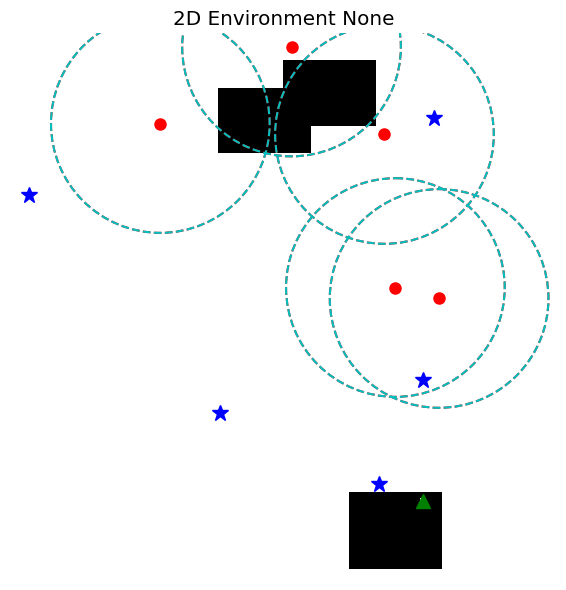

In [274]:
plot_2d_environment(Init_Environmet,
                     cov_radius=cov_radius,
                     con_radius=con_radius
					 )


# Loss Function

<div dir="rtl">

    توضیحات:
    تابع هزینه (WSNloss) که سه مؤلفه دارد:

        فاصله بین سنسورها (intra_distance_weight).

        پوشش نقاط هدف (target_distance_weight).

        اجتناب از موانع (obstacle_weight).

    کاربرد:
    این تابع به الگوریتم‌های بهینه‌سازی کمک می‌کند تا بهترین مکان‌ها برای سنسورها را پیدا کنند.

</div>

$$ 
f(X) = \sum_{X}  || x_i - x_j ||_2 + \sum_{T} || x_i - t_i ||_2 - \lambda      \text{||E||} \\

X : \text{sensors positions} \\
T : \text{targer point positions} \\
E : \text{environmet obsticle}
$$

In [275]:
def masked_centered_convolution_sum(x: Tensor, kernel_size: int = 3) -> Tensor:
    """
    Compute convolution sum centered on sensor positions, ignoring obstacles.
    
    Args:
        x (Tensor): 2D environment tensor (2: sensor, 1: obstacle, 0: free).
        kernel_size (int): Size of the convolution kernel.
    
    Returns:
        Tensor: Sum of convolution values at sensor positions.
    """
    # assert x.dim() == 2
    P , H, W = x.shape
    pad = kernel_size // 2

    kernel = torch.ones((kernel_size, kernel_size), dtype=x.dtype, device=x.device, requires_grad=True)
    total = torch.tensor(0.0, dtype=x.dtype, device=x.device, requires_grad=True)

    for p in range(P):
        # Iterate over each sensor position in the batch
        for i in range(pad, H - pad):
            for j in range(pad, W - pad):
                if x[p, i, j].item() == 2:
                    patch = x[p, i-pad:i+pad+1, j-pad:j+pad+1]
                    obstacle_mask = (patch != 1).float()
                    masked_patch = patch * obstacle_mask
                    total = total + (masked_patch * kernel).sum()
    # for i in range(pad, H - pad):
    #     for j in range(pad, W - pad):
    #         if x[i, j].item() == 2:
    #             patch = x[i-pad:i+pad+1, j-pad:j+pad+1]
    #             obstacle_mask = (patch != 1).float()
    #             masked_patch = patch * obstacle_mask
    #             total = total + (masked_patch * kernel).sum()

    return F.relu(total)

class WSNloss(nn.Module):
    def __init__(self,
                 env: torch.Tensor, 
                 Coverage_rate: int  = 3, 
                 Connection_rate: int  = 3,
                 target_points: torch.Tensor | None = None, 
                 sink_point: torch.Tensor | None = None,
                 obstacle_weight: float | Tensor  = 1.0, 
                 intra_distance_weight: float | Tensor = 1.0, 
                 target_distance_weight: float  | Tensor= 1.0
                ) -> None:
        super(WSNloss, self).__init__()
        self.Rs = torch.tensor(Coverage_rate)
        self.Rc = torch.tensor(Connection_rate)
        self.sink_point = torch.tensor(sink_point) if sink_point is not None else None
        
        # مدیریت نقاط هدف
        if target_points is not None:
            self.target_points = target_points
        else:
            self.target_points = None
            
        self.obstacle_weight = torch.tensor(obstacle_weight)
        self.intra_distance_weight = torch.tensor(intra_distance_weight)
        self.target_distance_weight = torch.tensor(target_distance_weight)
        
        # محیط و کانولوشن موانع
        self.env = env.float()
        kernel_size = 2 * Coverage_rate + 1
        self.conv = nn.Conv2d(1, 1, kernel_size, padding='same', bias=False)
        nn.init.constant_(self.conv.weight, 1.0)
        self.conv.requires_grad_(False)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        محاسبه تابع ضرر با در نظر گرفتن:
        1- فاصله بین سنسورها
        2- پوشش نقاط هدف
        3- اجتناب از موانع
        """
        device = X.device
        eps = torch.tensor(1e-1)
        # ==================== 1. فاصله بین سنسورها ====================
        intra_dists = torch.cdist(X, X, p=2)
        # print(intra_dists)
        # mask = intra_dists <= self.Rc  # سنسورهای نزدیکتر از Rc
        intra_loss = (torch.pow(self.Rc,2) - intra_dists )
        
        intra_loss2 = (eps - intra_dists )
        
        # ==================== 2. پوشش نقاط هدف ====================
        target_loss = torch.tensor(0.0 , requires_grad=True)
        intra_sink_loss = torch.tensor(0.0 , requires_grad=True)
        if self.target_points is not None:
            target_dists = torch.cdist(X, self.target_points, p=2)
            target_loss = (self.Rs - target_dists)#.sum() 
            
        if self.sink_point is not None:
            node_to_sink = torch.cdist(X, self.sink_point, 2)
            # mask = node_to_sink <= self.Rc
            intra_sink_loss = (self.Rc - node_to_sink)

        
        intra_loss_total = (intra_loss + intra_loss2).sum() + intra_sink_loss.sum()
        # print(f"{target_loss.shape} = {intra_loss.shape} + {intra_loss2.shape} . {intra_sink_loss.shape} * {target_loss.shape}")
		# ==================== 3. جریمه موانع ====================
        # تبدیل مختصات به اندیس‌های محیط
        h, w = self.env.shape
        coords = X[:, :2].clone()
        coords[:, 0] = torch.clamp((coords[:, 0] * w).long(), 0, w-1)
        coords[:, 1] = torch.clamp((coords[:, 1] * h).long(), 0, h-1)
        
        # محاسبه جریمه موانع
        # print("coords", coords.int())
        coords = coords.int()
        obstacle_penalty = self.env[coords[:, 1], coords[:, 0]].sum()
        
        # ==================== 4. جریمه خارج از محیط ====================
        out_of_bounds = ((X < 0) | (X > 1)).any(dim=1)
        boundary_penalty = out_of_bounds.float()#.sum()
        # print((obstacle_penalty + boundary_penalty).shape)
        
        # ==================== محاسبه ضرر نهایی ====================
        total_loss = (
            (self.intra_distance_weight * intra_loss_total) +
            (self.target_distance_weight * target_loss) -
            (self.obstacle_weight * (obstacle_penalty + boundary_penalty))
        )
        intra_loss_total_ = (intra_loss + intra_loss2).\
                matmul(target_loss).\
                    matmul(intra_sink_loss).t().sum(0) + (obstacle_penalty + boundary_penalty)
        
        # print(intra_loss_total_.shape)
        
        return intra_loss_total_


# Traditional Evolutionary Method

<div dir="rtl">

    توضیحات:
    کلاس DCPMK برای تعریف مسئله بهینه‌سازی با pymoo.

        _evaluate(): محاسبه هزینه برای هر فرد در جمعیت.

    کاربرد:
    پیاده‌سازی الگوریتم ژنتیک برای یافتن بهترین مکان‌های سنسور.

</div>

In [276]:
class DCPMK(Problem):
    def __init__(self, 
                 pop: Tensor, 
                 env: Tensor,
                 target_points: Tensor | None, 
                 fitness_fn: nn.Module,
                 )-> None:

        self.pop_size, self.n_sensors, self.ndim = pop.shape
        
        super(DCPMK, self).__init__(
            n_var =  self.n_sensors * self.ndim,
            n_obj= self.n_sensors,
            n_ieq_constr=0,
            xl=0.0,
            xu=1.0
        )

        self.env = env.detach().clone()
        # self.pos = pop.detach().clone()
        self.target_points = target_points.detach().clone() if target_points is not None else None

        self.fitness_fn = fitness_fn

    def _evaluate(self, X, out, *args, **kwargs):
        # super().evaluate(X, out, *args, **kwargs)
        # print(f"X {X.shape}")
        X_tensor : Tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False).\
            reshape(-1, self.n_sensors, self.ndim)
        # Reshape to (pop_size, n_sensors, ndim)

        losses = []
        for i in range(X_tensor.shape[0]):
            # Denormalize positions to environment size
            # X_denorm = denormalize_positions(X_tensor[i], self.env.shape)
            loss : Tensor = self.fitness_fn(X_tensor[i]).detach()
            # print(loss)
            losses.append(loss)
            
        # print(losses)
        out["F"] = torch.stack(losses).reshape(-1, Num_Sensor_Node)

In [277]:
from pymoo.termination import get_termination

class EvolutionAdaptation:
    
    def __init__(self,
    population : Tensor,
    new_env : Tensor,
    target_points : Tensor | None,
    fitness_fn : nn.Module,
    pos_init : Tensor ,
    cross_over_rate : float | int = 1,
    mutation_over_rate : float | int = 1,
    n_gen : int = 50
    ) -> None:
        """
        population: تنسور با اندازه (pop_size, n_sensors, ndim)
        new_env: محیط جدید به صورت تنسور
        target_points: نقطه هدف جدید به صورت تنسور
        fitness_fn: تابع هزینه برای ارزیابی موقعیت‌ها
        cross_over_rate: نرخ تقاطع برای الگوریتم ژنتیک
        mutation_over_rate: نرخ جهش برای الگوریتم ژنتیک
        pos_init: موقعیت اولیه به صورت تنسور
        n_iter: تعداد تکرارها برای الگوریتم ژنتیک
        """
        # Ensure population is (pop_size, n_sensors * ndim)
        self.pop_size, self.n_sensors, self.ndim = population.shape
        population = population.reshape(-1, self.n_sensors * self.ndim)


        self.population = population
        self.new_env = new_env
        self.new_target_points = target_points
        self.fitness_fn = fitness_fn
        self.cross_over_rate = cross_over_rate
        self.mutation_over_rate = mutation_over_rate
        self.pos_init = pos_init
        self.n_gen = n_gen
        # Ensure pos_init is 2D  or 3D 
        # pos_init = input_tensor.clone().detach()
        pass
    def __call__(self,population : Tensor,  n_gen: int = 50) -> Result:
        """
        n_gen: تعداد تکرارها برای الگوریتم 
        """
        # Ensure population is (pop_size, n_sensors * ndim)
        # print(population.shape)
        pop_numpy = population .reshape(-1, 
                     population.shape[0] * population.shape[1])

        # Define GA algorithm
        # print(f"pop_numpy.shape[0] {pop_numpy.shape[0]}")
        algorithm = PSO(
            pop_size= pop_size, 
            n_offsprings = None, 
            n_diffs = 1,
            archive=None,
            crossover=SBX(eta=1, prob= self.cross_over_rate),
            mutation=PM(eta=1, prob= self.mutation_over_rate),
        )

        # Define problem
        problem = DCPMK(
            pop=self.pos_init,
            env=self.new_env,
            target_points=self.new_target_points,
            fitness_fn= self.fitness_fn,

        )
        # from pymoo.core.termination import Termination
        
        # Termination().update (algorithm)
        # Run optimization
        res = minimize(
            problem,
            algorithm,
            X=pop_numpy,  # ← مقدار اولیه
            termination= get_termination("n_gen", 1),  # Changed to 'n_gen' for clarity
            seed=SEED,
            save_history=False,
            save_archive=False,
            verbose=False,
            return_least_infeasible=False
        )

        return res

# make network

<div dir="rtl">

    توضیحات:
    کلاس NetWorkAdapter یک شبکه عصبی ساده برای پیش‌بینی موقعیت‌های بهینه سنسورهاست.

        از لایه‌های Linear و LSTM استفاده می‌کند.

    کاربرد:
    کمک به فرآیند بهینه‌سازی با یادگیری ماشین.

</div>

In [278]:
class NetWorkAdapter(nn.Module):
    def __init__(self,num_pop: int,
                   num_sensor : int,
                  dimension : int ,
                     *args, **kwargs) -> None:
        
        super().__init__(*args, **kwargs)
        self.input_size : int = dimension
        self.num_pop = num_pop
        self.num_sensor = num_sensor
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=dimension, out_features=dimension),
            # nn.ReLU(),
            nn.Sigmoid(),
            # nn.Linear(in_features=128, out_features=32),
            # nn.ReLU(),
            # nn.Linear(in_features=32, out_features=64),
            # nn.ReLU()
            
        )
        # self.h0 = torch.randn(num_pop,24,  32)
        # self.c0 = torch.randn(num_pop, 24, 32)

        self.lstm = nn.LSTM(input_size=dimension, 
                            hidden_size= 16, 
                            num_layers=2, 
                            batch_first=True,
                            bidirectional=False)
        self.fc2 = nn.Sequential(
                    nn.Linear(in_features=16, out_features=dimension),
                    nn.Sigmoid(),
                    # nn.Linear(in_features=64, out_features=input_size),
                    # nn.Sigmoid()
                            )
        pass

    def forward(self, x : Tensor) -> Tensor:
        x = self.fc1(x)
        rnn, (h,c) = self.lstm(x)

        x = self.fc2(
            rnn
		)
        # print(x)
        # denormed = denormalize_positions(x, (100,100))
        return x


# Define Model

<div dir="rtl">

    توضیحات:
    در این بخش:

        fitness_fn: نمونه‌ای از تابع هزینه.

        network_adaptor: مدل شبکه عصبی.

        optimizer: بهینه‌ساز RMSprop برای آموزش شبکه.

        evolution_adpator: پیاده‌سازی الگوریتم ژنتیک.

    کاربرد:
    آماده‌سازی مدل‌ها و ابزارهای بهینه‌سازی.

</div>

In [279]:
# تعریف مدل و تابع ضرر
from torch.nn import MSELoss

# Define the fitness function
fitness_fn = WSNloss(
    Coverage_rate= Coverage_rate,
    env= Environmet,
    target_points=target_points[0],
    sink_point= SINK_POSITION, 
    obstacle_weight= obstacle_weight ,
    intra_distance_weight = intra_distance_weight,
    target_distance_weight = target_distance_weight
)

model_loss = MSELoss()
# Define the network adapter
network_adaptor : NetWorkAdapter = NetWorkAdapter(pop_size, 
                                                  Num_Sensor_Node,
                                                  Dimension)
# Define the optimizer
optimizer = RMSprop(network_adaptor.parameters(), 
                lr= Learning_rate,
                alpha=.9,
                eps=1e-8,
                centered=True,
                momentum=0.9,
                weight_decay=1e-2,
                maximize= False
				)
# Define the evolution adaptation
evolution_adpator = EvolutionAdaptation(
    population=Sensor_Nodes,
    new_env=Environmet,
    target_points=target_points,
    fitness_fn=fitness_fn,
    pos_init=Sensor_Nodes,
    cross_over_rate=0.5,
    mutation_over_rate=0.5,
    n_gen=1
)


print(f"""
Loss Function: {fitness_fn}
{25*'-'}
NetWorks: {network_adaptor}
{25*'-'}
Optimizer: {optimizer}
{25*'-'}
Network Adapter: {network_adaptor}
""")


Loss Function: WSNloss(
  (conv): Conv2d(1, 1, kernel_size=(41, 41), stride=(1, 1), padding=same, bias=False)
)
-------------------------
NetWorks: NetWorkAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (lstm): LSTM(2, 16, num_layers=2, batch_first=True)
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=2, bias=True)
    (1): Sigmoid()
  )
)
-------------------------
Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.9
    capturable: False
    centered: True
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    weight_decay: 0.01
)
-------------------------
Network Adapter: NetWorkAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (lstm): LSTM(2, 16, num_layers=2, batch_first=True)
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

C:\Users\Nemo\AppData\Local\Temp\ipykernel_16980\823854332.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sink_point = torch.tensor(sink_point) if sink_point is not None else None


# Runing Functions

In [280]:
# Define the network adaptation function
def network_adapt(
	input_tensor: Tensor,
	num_epochs: int = 1,
	verbose: bool = False,
) -> tuple[Tensor, Tensor]:
	network_adaptor.train()
	# input_tensor = input_tensor.detach().clone().requires_grad_(True)
	last_loss = 0.
	
	for epoch in range(num_epochs):
		optimizer.zero_grad()

		output : Tensor = network_adaptor(input_tensor)
		# loss : Tensor = fitness_fn(output)
		loss : Tensor = fitness_fn(output)

		# loss.backward()
		# # Optional: gradient clipping for stability
		# torch.nn.utils.clip_grad_norm_(network_adaptor.parameters(), max_norm=1.0)
		# optimizer.step()

		# last_loss : float = loss.item()
		if ((epoch + 1) % 20 == 0 or epoch == 0) and verbose:
			print(f"Epoch {epoch + 1}:{num_epochs}, Loss: {loss:.4f}")

	return output, loss


In [281]:
# Define the evolution adaptation function
def evolution_adpat(
		input_tensor : Tensor, 
		n_gen: int = 50
	) -> tuple[Tensor, Tensor]:
	"""
	input_tensor: تنسور ورودی با اندازه (pop_size, n_sensors, ndim)
	n_iter: تعداد تکرارها برای الگوریتم 
	"""
	result : Result = evolution_adpator(input_tensor,  n_gen=n_gen)
	# print(f"result.pop {result.pop.get("X").shape}")
	optimized_positions : Tensor = torch.tensor(result.X,
											#  .reshape(-1, Num_Sensor_Node, 2),
											 requires_grad=True).float().reshape(-1, Num_Sensor_Node, Dimension) # type: ignore
	# print(f"result.X {result.X.shape}, optimized_positions {optimized_positions.shape}")
	F : Tensor = torch.tensor(result.pop.get("F"), requires_grad=True) # type: ignore #.reshape(-1, X, 2)

	# optimized_positions_denorm = denormalize_positions(optimized_positions , ENV_SIZE)
	return optimized_positions[-1] , F.mean()



# Run Simulation

<div dir="rtl">

    توضیحات:
    حلقه اصلی شبیه‌سازی که در هر نسل:

        با شبکه عصبی (network_adapt) یا الگوریتم ژنتیک (evolution_adpat) موقعیت‌ها را به‌روز می‌کند.

        بهترین پاسخ را ذخیره می‌کند.

    کاربرد:
    اجرای فرآیند بهینه‌سازی و ذخیره نتایج.

</div>

In [282]:
print(f"""
Sensor_Nodes: {Sensor_Nodes.shape}
target pointss: {target_points.shape}
sink : {SINK_POSITION}
Environmet: {Environmet.shape}
""")


Sensor_Nodes: torch.Size([100, 5, 2])
target pointss: torch.Size([100, 5, 2])
sink : tensor([[0.8682, 0.7592]])
Environmet: torch.Size([100, 100])



In [283]:
ft_dure_gen : list = list()
losses : list = list()
archive : list[Tensor] = list()
time_to_run = list()
archiveLen : int = 100

torch.autograd.set_detect_anomaly(False)
firstX = Sensor_Nodes.clone()
# print(f"firstX.shape {firstX.shape}")
for gen in range(n_simu):
	# print(firstX.shape)
	firstX = Sensor_Nodes.clone()

	start_time = time.time()
	for PopX in firstX:
		head = torch.rand(1).item() < chance_in_net_favor   

		if head and gen >= 1:
			# print("Network Adaptation")
			newX, newX_fitness = network_adapt(PopX, n_epoch, False)
		else:
			# print("Evolution Adaptation")
			newX, newX_fitness = evolution_adpat(PopX, 1)
		
		ft_dure_gen.append(newX_fitness.mean().item()) 
		
		# print(PopX.shape, newX.shape)

		if torch.all(
				(fitness_fn(newX)) <\
			    (fitness_fn(PopX))
					):
			archive.append(newX.detach().clone().requires_grad_())
		else:
			archive.append(PopX.detach().clone().requires_grad_())

		for x1  in archive:
			# print(f"{x1.shape}")
			loss : Tensor = fitness_fn(x1)
			loss.backward(retain_graph=True,
				  gradient=torch.ones_like(loss))
			# torch.nn.utils.clip_grad_norm_(network_adaptor.parameters(), max_norm=1.0)

			optimizer.step()




		end_time = time.time()
		time_delay = (end_time - start_time) * 1000 
		time_to_run.append(time_delay)
		
	losses.append(newX_fitness.mean().item())

	# firstX = newX.detach()#.clone().requires_grad_()
	archive = archive[:archiveLen]
	print(f"Generation {gen+1} | {newX_fitness.mean().item(): .4f} | {"'NET'" if head and gen >= 1 else "'EA'"} ")
	# break


Generation 1 |  9879.1325 | 'EA' 
Generation 2 |  11444.2158 | 'NET' 
Generation 3 |  11444.2158 | 'NET' 
Generation 4 |  11444.2158 | 'NET' 
Generation 5 |  11444.2158 | 'NET' 
Generation 6 |  9865.7861 | 'EA' 
Generation 7 |  9846.2471 | 'EA' 
Generation 8 |  11444.2158 | 'NET' 
Generation 9 |  9843.4881 | 'EA' 
Generation 10 |  11444.2158 | 'NET' 


In [284]:
newX

tensor([[0.4942, 0.5404],
        [0.4928, 0.5367],
        [0.4927, 0.5351],
        [0.4930, 0.5345],
        [0.4932, 0.5343]], grad_fn=<SigmoidBackward0>)

# Visulizing Result

<div dir="rtl">

    توضیحات:

        best_denorm: تبدیل بهترین موقعیت‌ها به مختصات واقعی.

        plot_2d_environment(): نمایش محیط نهایی با سنسورها و نقاط هدف.

    کاربرد:
    مشاهده و تحلیل نتایج نهایی بهینه‌سازی.

</div>

In [285]:
len(archive), archive[0].shape, archive[2].shape

(100, torch.Size([5, 2]), torch.Size([5, 2]))

In [286]:
archive= torch.stack(archive)#.reshape(-1,Num_Sensor_Node, 2)

# archive= torch.stack([torch.stack([a.detach()]) for a in archive])#.reshape(-1,Num_Sensor_Node, 2)

In [287]:
archive.shape

torch.Size([100, 5, 2])

In [288]:
best_denorm = torch.stack([denormalize_positions(archive[i] , ENV_SIZE).detach()
               for i in range(len(archive))])

best_answer = find_best(best_denorm, fitness_fn,best_as= 'min', verbose=True) 
print(best_answer.int(), "Best Answer found in the population.")
opt_env = positioning_nodes(Environmet, 
                            best_answer, 
                            defines_as=2)
# print(torch.count_nonzero(opt_env == 2), "Sensors placed in the environment.")

Best Answer is in index: 35
tensor([[10, 94],
        [ 3,  8],
        [54, 94],
        [96, 73],
        [97,  3]], dtype=torch.int32) Best Answer found in the population.


In [289]:
# print(best_answer.shape)
print("Optimized Env ", torch.count_nonzero(opt_env == 2), "Sensors placed in the environment.")
print("Optimized Env ", torch.count_nonzero(opt_env == 3), "Target placed in the environment.")
print("Optimized Env ", torch.count_nonzero(opt_env == 4), "sink placed in the environment.")

Optimized Env  tensor(5) Sensors placed in the environment.
Optimized Env  tensor(5) Target placed in the environment.
Optimized Env  tensor(1) sink placed in the environment.


## Best Env Optimized Find

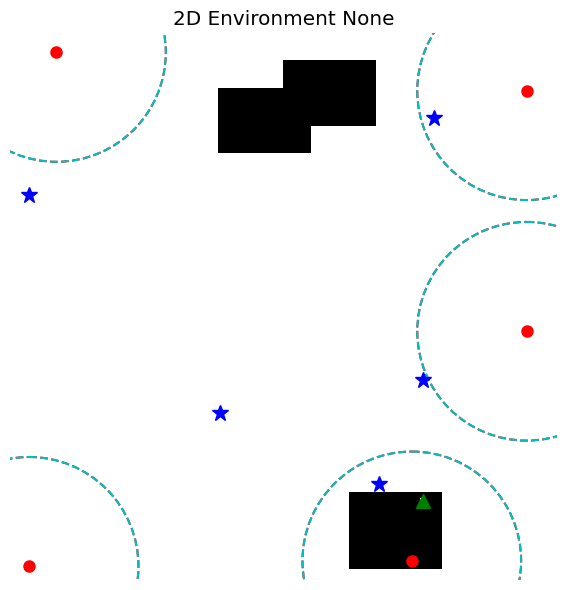

In [290]:
try:
	plot_2d_environment(opt_env, cov_radius=cov_radius
                     , con_radius=con_radius)
except Exception as e:
	print(f"Error in plotting environment: {e}")

## loss and fitness graphing

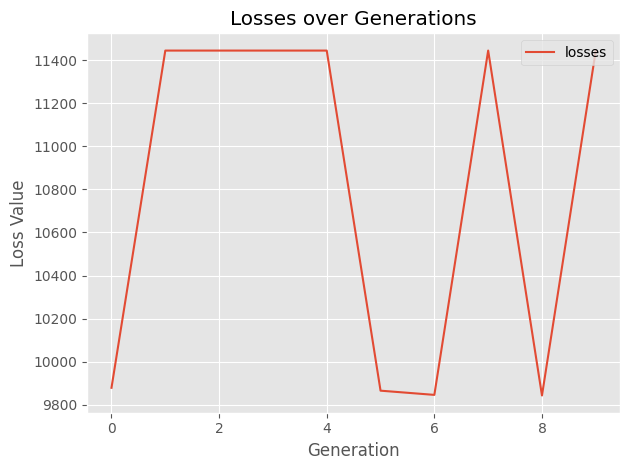

In [291]:
style.use("ggplot")
sns.lineplot({
              "losses": losses})
plt.title("Losses over Generations")
plt.xlabel("Generation")
plt.ylabel("Loss Value")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

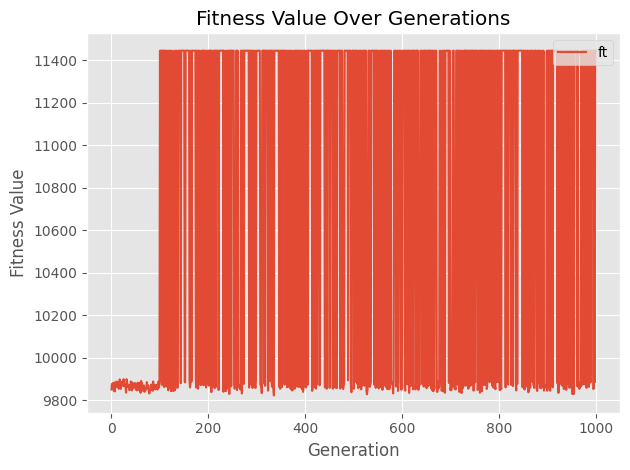

In [292]:
style.use("ggplot")
sns.lineplot({
    "ft":ft_dure_gen,})
plt.title("Fitness Value Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

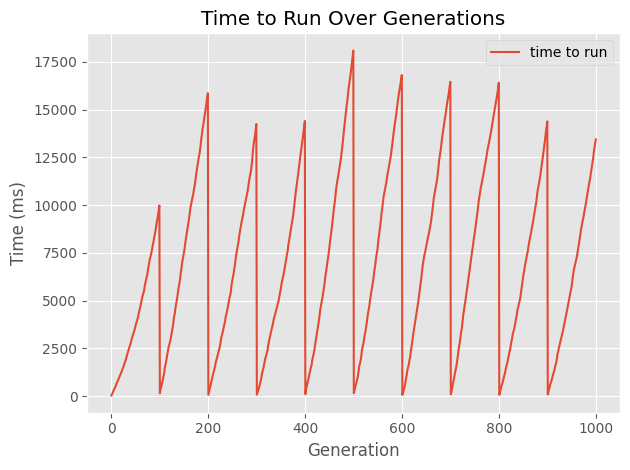

In [293]:
style.use("ggplot")
sns.lineplot({
              "time to run": time_to_run
              })
plt.title("Time to Run Over Generations")
plt.xlabel("Generation")

plt.ylabel("Time (ms)")
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [294]:
all_denoremd = [positioning_nodes(Environmet, node) for node in best_denorm]

for i, envs in enumerate(all_denoremd):
	break
	try:
		plot_2d_environment(envs, 
						cov_radius=cov_radius,
						con_radius=con_radius,
						edit=f"Generation {i+1}")
	except Exception as e:
		print(f"Error in plotting generation {i+1}: {e}")
		break